In [2]:
from scipy.stats import multivariate_normal as mnorm
from scipy.stats import norm
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import inv
import math
from tqdm import tqdm
from scipy.optimize import minimize, basinhopping
import optuna

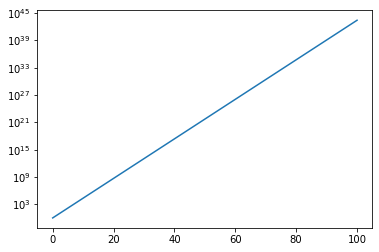

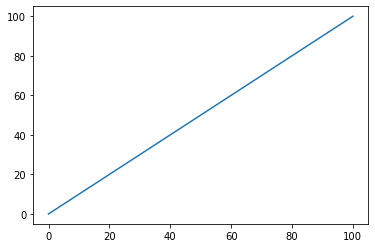

In [8]:
x = np.linspace(0,100,1000)
y = np.exp(x)
plt.plot(x,y)
plt.yscale('log')

fig = plt.figure()
plt.plot(x,np.log(y))

# Vanilla GRP from hao wu, with gradient info

sigma_f = 0.97
sigma_l = 1.81
kst forming (5, 101) (2, 101)
(7, 101)
0.00937894421164287


/tmp/ipykernel_4734/1761740093.py:136: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


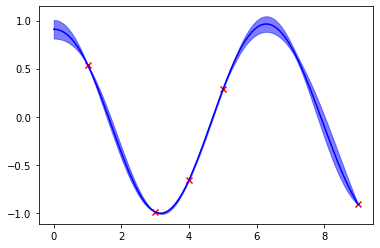

In [5]:
import numpy as np
import logging
from scipy.linalg import inv, cholesky, cho_solve, solve_triangular
from scipy.optimize import minimize

logger = logging.getLogger('lgi')


class GPR(object):
    def __init__(self, x_train, y_train, x_deriv_train=None, y_deriv_train=None,
                 y_train_noise=None, y_deriv_train_noise=None):
        if x_train is None or y_train is None:
            self.x_train = np.array([])
            self.y_train = np.array([])
        else:
            self.x_train = x_train
            self.y_train = y_train
        if x_deriv_train is None or y_deriv_train is None:
            self.x_deriv_train = np.array([])
            self.y_deriv_train = np.array([])
        else:
            self.x_deriv_train = x_deriv_train
            self.y_deriv_train = y_deriv_train
        self.y_train_full = np.hstack([self.y_train, self.y_deriv_train])
        if y_train_noise is None:
            y_train_noise = np.zeros_like(y_train)
        if y_deriv_train_noise is None:
            y_deriv_train_noise = np.zeros_like(y_deriv_train)
        self.cov_d = np.diag(np.hstack((y_train_noise**2,
                                        y_deriv_train_noise**2)))
        self.hypers = {'sigma_f': 1.0,
                       'sigma_l': 0.5}
        
    def get_cov(self):
        """
        Squared exponential kernel
        """
        K_n_n = self.hypers['sigma_f'] ** 2 * \
                np.exp(- 0.5 * (self.x_train[:, np.newaxis] - self.x_train[np.newaxis, :]) ** 2 / self.hypers['sigma_l'] ** 2)
        K_n_p = self.hypers['sigma_f'] ** 2 / self.hypers['sigma_l'] ** 2 * \
                (self.x_train[:, np.newaxis] - self.x_deriv_train[np.newaxis, :]) * \
                np.exp(- 0.5 * (self.x_train[:, np.newaxis] - self.x_deriv_train[np.newaxis, :]) ** 2 / self.hypers['sigma_l'] ** 2)
        K_p_n = K_n_p.T
        K_p_p = self.hypers['sigma_f'] ** 2 / self.hypers['sigma_l'] ** 2 * \
                (1 - (self.x_deriv_train[:, np.newaxis] - self.x_deriv_train[np.newaxis, :]) ** 2 / self.hypers['sigma_l'] ** 2) * \
                np.exp(- 0.5 * (self.x_deriv_train[:, np.newaxis] - self.x_deriv_train[np.newaxis, :]) ** 2 / self.hypers['sigma_l'] ** 2)
        K = np.block([[K_n_n, K_n_p],
                      [K_p_n, K_p_p]]) + self.cov_d
        K[np.diag_indices_from(K)] += 1e-8
        return K

    def get_cov_star(self, x_test):
        K_n_t = self.hypers['sigma_f'] ** 2 * \
                np.exp(- 0.5 * (self.x_train[:, np.newaxis] - x_test[np.newaxis, :]) ** 2 / self.hypers['sigma_l'] ** 2)
        K_p_t = - self.hypers['sigma_f'] ** 2 / self.hypers['sigma_l'] ** 2 * \
                (self.x_deriv_train[:, np.newaxis] - x_test[np.newaxis, :]) * \
                np.exp(- 0.5 * (self.x_deriv_train[:, np.newaxis] - x_test[np.newaxis, :]) ** 2 / self.hypers['sigma_l'] ** 2)
        print('kst forming', K_n_t.shape, K_p_t.shape)
        return np.block([[K_n_t], [K_p_t]])

    def get_cov_star_star(self, x_test):
        K = self.hypers['sigma_f'] ** 2 * np.exp(- 0.5 * (x_test[:, np.newaxis] - x_test[np.newaxis, :]) ** 2 / self.hypers['sigma_l'] ** 2)
        K[np.diag_indices_from(K)] += 1e-8
        return K

    def set_hypers(self, hypers):
        self.hypers['sigma_f'] = hypers[0]
        self.hypers['sigma_l'] = hypers[1]

    def get_loss(self, hypers):
        self.set_hypers(hypers)
        K = self.get_cov()
        try:
            L = cholesky(K, lower=True, check_finite=False)
        except np.linalg.LinAlgError:
            return np.inf
        # compute the loss
        v = solve_triangular(L, self.y_train_full, lower=True, check_finite=False)
        loss = 2 * np.log(np.diag(L)).sum() + v.T @ v
        logger.debug(f"{['{:.2f}'.format(x) for x in hypers]}: {loss:.2f}")
        return loss

    def fit(self):
        x0 = np.array([self.hypers['sigma_f'], self.hypers['sigma_l']])
        result = minimize(fun=self.get_loss, x0=x0)
        hypers_opt = result.x
        self.hypers['sigma_f'] = hypers_opt[0]
        self.hypers['sigma_l'] = hypers_opt[1]
        print(f"sigma_f = {self.hypers['sigma_f']:.2f}")
        print(f"sigma_l = {self.hypers['sigma_l']:.2f}")

    def predict(self, x_test):
        K = self.get_cov()
        try:
            L = cholesky(K, lower=True, check_finite=False)
        except np.linalg.LinAlgError as exc:
            exc.args = (
                           "The kernel is not returning a positive "
                           "definite matrix.",
                       ) + exc.args
            raise
        K_star = self.get_cov_star(x_test)
        print(K_star.shape)
        K_star_star = self.get_cov_star_star(x_test)
        alpha = cho_solve((L, True), self.y_train_full, check_finite=False)
        y_star = K_star.T @ alpha
        v = solve_triangular(L, K_star, lower=True, check_finite=False)
        cov_star = K_star_star - v.T @ v
        post_mean = y_star
        post_cov = cov_star
        return post_mean, post_cov
    
if __name__ == '__main__':
    def y_fun(x, noise_sigma=0.0):
        x = np.asarray(x)
        y = np.cos(x) + np.random.normal(0, noise_sigma, size=x.shape)
        return y

    x_train = np.array([1, 3, 4, 5, 9])
    y_train = y_fun(x_train, noise_sigma=1e-4)
    x_deriv_train = np.array([0.0, 2 * np.pi])
    y_deriv_train = np.array([0.0, 0.0])
    x_test = np.linspace(0, 9, 101)
    gpr = GPR(x_train, y_train, x_deriv_train, y_deriv_train)
    gpr.fit()
    y_test, cov_test = gpr.predict(x_test)
    print(cov_test[0,0])
    std = np.sqrt(np.diag(cov_test))
    y_lower = y_test - std
    y_upper = y_test + std
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(x_test, y_test, 'b-')
    ax.fill_between(x_test, y_lower, y_upper, color='blue', alpha=0.5)
    ax.scatter(x_train, y_train, color='red', marker='x')
    fig.show()

In [1]:
import numpy as np
a = np.array([1,2,3])
b = np.array([1,2,4])
c = np.array([1,2,5])
d = np.array([1,2,6])
K = np.block([[a, b],
            [c, d]])
K

array([[1, 2, 3, 1, 2, 4],
       [1, 2, 5, 1, 2, 6]])

In [ ]:
import numpy as np
import logging
from scipy.linalg import inv, cholesky, cho_solve, solve_triangular
from scipy.optimize import minimize

logger = logging.getLogger('lgi')


class GPR(object):
    def __init__(self, x_train, y_train, x_deriv_train=None, y_deriv_train=None,
                 y_train_noise=None, y_deriv_train_noise=None):
        M = len(x_train)
        M_p = len(x_deriv_train)
        if x_train is None or y_train is None:
            self.x_train = np.array([])
            self.y_train = np.array([])
        else:
            self.x_train = x_train
            self.y_train = y_train
        if x_deriv_train is None or y_deriv_train is None:
            self.x_deriv_train = np.array([])
            self.y_deriv_train = np.array([])
        else:
            self.x_deriv_train = x_deriv_train
            self.y_deriv_train = y_deriv_train
        self.y_train_full = np.hstack([self.y_train, self.y_deriv_train])
        if y_train_noise is None:
            y_train_noise = np.zeros_like(y_train)
        if y_deriv_train_noise is None:
            y_deriv_train_noise = np.zeros_like(y_deriv_train)
        self.cov_d = np.diag(np.hstack((y_train_noise**2,
                                        y_deriv_train_noise**2)))
        self.prior_mean = None
        self.prior_kernel = None
        self.hypers = {'amp_n': np.repeat(1,M),
                       'amp_p': np.repeat(1,M_p),
                       'l_n': np.repeat(0.5,M),
                       'l_p': np.repeat(0.5,M_p)}
        
    def get_cov(self):
        """
        Squared exponential kernel
        """
        K_n_n = self.hypers['sigma_f'] ** 2 * \
                np.exp(- 0.5 * (self.x_train[:, np.newaxis] - self.x_train[np.newaxis, :]) ** 2 / self.hypers['sigma_l'] ** 2)
        K_n_p = self.hypers['sigma_f'] ** 2 / self.hypers['sigma_l'] ** 2 * \
                (self.x_train[:, np.newaxis] - self.x_deriv_train[np.newaxis, :]) * \
                np.exp(- 0.5 * (self.x_train[:, np.newaxis] - self.x_deriv_train[np.newaxis, :]) ** 2 / self.hypers['sigma_l'] ** 2)
        K_p_n = K_n_p.T
        K_p_p = self.hypers['sigma_f'] ** 2 / self.hypers['sigma_l'] ** 2 * \
                (1 - (self.x_deriv_train[:, np.newaxis] - self.x_deriv_train[np.newaxis, :]) ** 2 / self.hypers['sigma_l'] ** 2) * \
                np.exp(- 0.5 * (self.x_deriv_train[:, np.newaxis] - self.x_deriv_train[np.newaxis, :]) ** 2 / self.hypers['sigma_l'] ** 2)
        K = np.block([[K_n_n, K_n_p],
                      [K_p_n, K_p_p]]) + self.cov_d
        K[np.diag_indices_from(K)] += 1e-8
        return K

    def get_cov_star(self, x_test):
        K_n_t = self.hypers['sigma_f'] ** 2 * \
                np.exp(- 0.5 * (self.x_train[:, np.newaxis] - x_test[np.newaxis, :]) ** 2 / self.hypers['sigma_l'] ** 2)
        K_p_t = - self.hypers['sigma_f'] ** 2 / self.hypers['sigma_l'] ** 2 * \
                (self.x_deriv_train[:, np.newaxis] - x_test[np.newaxis, :]) * \
                np.exp(- 0.5 * (self.x_deriv_train[:, np.newaxis] - x_test[np.newaxis, :]) ** 2 / self.hypers['sigma_l'] ** 2)
        return np.block([[K_n_t], [K_p_t]])

    def get_cov_star_star(self, x_test):
        K = self.hypers['sigma_f'] ** 2 * np.exp(- 0.5 * (x_test[:, np.newaxis] - x_test[np.newaxis, :]) ** 2 / self.hypers['sigma_l'] ** 2)
        K[np.diag_indices_from(K)] += 1e-8
        return K

    def set_hypers(self, hypers):
        self.hypers['sigma_f'] = hypers[0]
        self.hypers['sigma_l'] = hypers[1]

    def get_loss(self, hypers):
        self.set_hypers(hypers)
        K = self.get_cov()
        try:
            L = cholesky(K, lower=True, check_finite=False)
        except np.linalg.LinAlgError:
            return np.inf
        # compute the loss
        v = solve_triangular(L, self.y_train_full, lower=True, check_finite=False)
        loss = 2 * np.log(np.diag(L)).sum() + v.T @ v
        logger.debug(f"{['{:.2f}'.format(x) for x in hypers]}: {loss:.2f}")
        return loss

    def fit(self):
        x0 = np.array([self.hypers['sigma_f'], self.hypers['sigma_l']])
        result = minimize(fun=self.get_loss, x0=x0)
        hypers_opt = result.x
        self.hypers['sigma_f'] = hypers_opt[0]
        self.hypers['sigma_l'] = hypers_opt[1]
        print(f"sigma_f = {self.hypers['sigma_f']:.2f}")
        print(f"sigma_l = {self.hypers['sigma_l']:.2f}")

    def predict(self, x_test):
        K = self.get_cov()
        try:
            L = cholesky(K, lower=True, check_finite=False)
        except np.linalg.LinAlgError as exc:
            exc.args = (
                           "The kernel is not returning a positive "
                           "definite matrix.",
                       ) + exc.args
            raise
        K_star = self.get_cov_star(x_test)
        K_star_star = self.get_cov_star_star(x_test)
        alpha = cho_solve((L, True), self.y_train_full, check_finite=False)
        y_star = K_star.T @ alpha
        v = solve_triangular(L, K_star, lower=True, check_finite=False)
        cov_star = K_star_star - v.T @ v
        post_mean = y_star
        post_cov = cov_star
        return post_mean, post_cov
    
if __name__ == '__main__':
    def y_fun(x, noise_sigma=0.0):
        x = np.asarray(x)
        y = np.cos(x) + np.random.normal(0, noise_sigma, size=x.shape)
        return y

    x_train = np.array([1, 3, 4, 5, 9])
    y_train = y_fun(x_train, noise_sigma=1e-4)
    x_deriv_train = np.array([0.0, 2 * np.pi])
    y_deriv_train = np.array([0.0, 0.0])
    x_test = np.linspace(0, 9, 100)
    gpr = GPR(x_train, y_train, x_deriv_train, y_deriv_train)
    gpr.fit()
    y_test, cov_test = gpr.predict(x_test)
    std = np.sqrt(np.diag(cov_test))
    y_lower = y_test - std
    y_upper = y_test + std
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(x_test, y_test, 'b-')
    ax.fill_between(x_test, y_lower, y_upper, color='blue', alpha=0.5)
    ax.scatter(x_train, y_train, color='red', marker='x')
    fig.show()

In [4]:
import numpy as np
a = np.array([1,2,3,4])
# a[:,np.newaxis]
a

array([1, 2, 3, 4])

# Simple Regression Problem

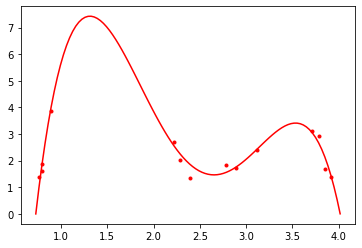

In [ ]:
rng = np.random.default_rng(seed=1354)
N = 100
exp_er = 0.2 #10
# def truef(x):
#     return x**2+1
def truef(x):
    a,b,c,d,e,f = -1.6,1.8,-6,0,2.4,2.5
    return -(e*(x-f)**4+d*(x-f)**3+c*(x-f)**2+b*(x-f)+a)
x = np.linspace(0.729,4.015,N) #(1,10,10)
y = truef(x)
xd_indicies = [int(1*(N/100)),int(2*(N/100)),int(2.5*(N/100)),int(5*(N/100)),int(45*(N/100)),int(47*(N/100)),int(50*(N/100)),int(62*(N/100)),int(65*(N/100)),int(72*(N/100)),int(90*(N/100)),int(92*(N/100)),int(94*(N/100)),int(96*(N/100))]
# xd_indicies = np.linspace(0,N-1,20).astype(int)
# xd_indicies = range(N)
xd = x[xd_indicies]
M = len(xd)
yd = rng.normal(loc=truef(xd),scale=exp_er)

figSRP = plt.figure()
plt.plot(x,y,'r')
plt.plot(xd,yd,'r.')
plt.show()

prior_mean_vector = np.repeat(4,N)

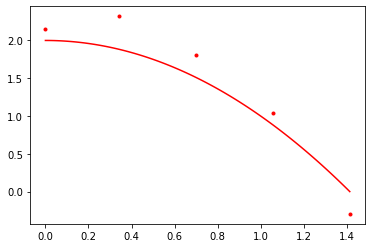

In [89]:
#Parabilic Electron Density
rng = np.random.default_rng(seed=1245)
N = 100
exp_er = 0.2 #10
def para(x):
    return -x**2+2
x = np.linspace(0,1.414,N)
y = para(x)
# xd_indicies = [int(1*(N/100)),int(2*(N/100)),int(2.5*(N/100)),int(5*(N/100)),int(45*(N/100)),int(47*(N/100)),int(50*(N/100)),int(62*(N/100)),int(65*(N/100)),int(72*(N/100)),int(90*(N/100)),int(92*(N/100)),int(94*(N/100)),int(96*(N/100))]
xd_indicies = np.linspace(0,N-1,5).astype(int)
# xd_indicies = range(N)

# y DATA
xd = x[xd_indicies]
M = len(xd)
yd = rng.normal(loc=para(xd),scale=exp_er)

#y' data
xprime = np.linspace(0,1.414,50)
xdprime = np.array([0])
Mprime = len(xdprime)
ydprime = np.array([0])

figSRP = plt.figure()
plt.plot(x,y,'r')
plt.plot(xd,yd,'r.')
plt.show()

prior_mean_vector = np.repeat(4,N)

# Using Hao Wu's Vanilla GPR with Gradient Information

sigma_f = 2.05
sigma_l = 1.18


/tmp/ipykernel_7535/3493710785.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


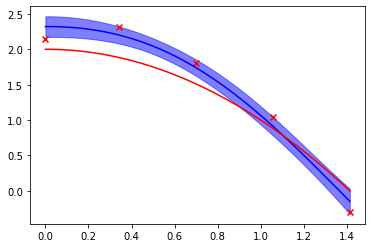

In [92]:
#Artificail observation of near 0 at edge and gradient 0 at core
artificial_obsv = GPR(xd, yd, xdprime, ydprime, y_train_noise=np.repeat(exp_er, M), y_deriv_train_noise=np.array([0.1]))

artificial_obsv.fit()
y_test, cov_test = artificial_obsv.predict(x)
std = np.sqrt(np.diag(cov_test))
y_lower = y_test - std
y_upper = y_test + std
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, y_test, 'b-')
ax.fill_between(x, y_lower, y_upper, color='blue', alpha=0.5)
ax.scatter(xd, yd, color='red', marker='x')
ax.plot(x,y,'r')
fig.show()


# Gaussian Process Regression 3
See notes, uses bayes theorum and the prediction can have many x values. Also applicable to interferometry. 

In [98]:
#These are necessary to avoid 0 and infinities from inv and det of large matracies
def chol_inv(A):
    L = np.linalg.cholesky(A)
    return np.linalg.inv(L).T @ np.linalg.inv(L)
def chol_det(A):
    L = np.linalg.cholesky(A)
    return np.prod(np.diag(L))

      fun: 1.2245165165839578
 hess_inv: array([[3.3114752 , 0.63771611],
       [0.63771611, 0.29994375]])
      jac: array([ 1.93715096e-07, -1.80304050e-06])
  message: 'Optimization terminated successfully.'
     nfev: 36
      nit: 8
     njev: 12
   status: 0
  success: True
        x: array([2.39833568, 0.93136367])
best Marge Li 1.2245165165839578


Not good if zero, as need to be inverted.


K [[5.75201406 5.75133773 5.74930924 5.74593001]
 [5.75133773 5.75201406 5.75133773 5.74930924]
 [5.74930924 5.75133773 5.75201406 5.75133773]
 [5.74593001 5.74930924 5.75133773 5.75201406]]
The Determinent of K is: 0.0
The Determinent of cov_li is: 0.0003200000000000001
The Determinent of cov_post3 is: 0.0


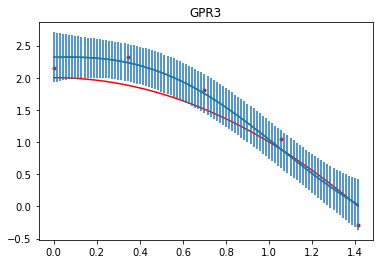

In [100]:
##Prior
mu_prior = prior_mean_vector
#exponential square kernel
def Kernel(x1,x2,params):
    x1 = x1
    x2 = x2
    #amplitude determins how far the model can go from the mean
    amp = params[0]
    #length scale determines smoothness, how correlated the function should be at a distance
    l = params[1]
    return amp**2 * np.exp(-((x1-x2)*(x1-x2))/(2*l**2))

def KRcov_li(params,trial_exp_er):
    X1, X2 = np.meshgrid(x,x)
    #covergence matrix of Prior
    K = Kernel(X1,X2,params)
    #add a small term onto diagonal of matricies to be inverted.
    #this ensures it is positive definate and cholensky matrix can be computed
    K[np.diag_indices_from(K)] += 1e-8 
    #covergence matrix of Likelyhood
    cov_li = np.diag(np.repeat(trial_exp_er,len(xd)))
    #R is a matrix that can take a potential function vector f_N and only return M values corresponding to f(x_1)...f(x_M) 
    R = np.zeros((M,N))
    for i in range(M):
        R[i,xd_indicies[i]]=1
    return K, R, cov_li


def MargLi(params):
    K, R, cov_li = KRcov_li(params,exp_er)
    invertable = cov_li+R@K@R.T
    #add a small term onto diagonal of matricies to be inverted.
    #this ensures it is positive definate and cholensky matrix can be computed
    invertable[np.diag_indices_from(invertable)] += 1e-8 
#     try:
#         L = np.linalg.cholesky(test_matrix)
#     except np.linalg.LinAlgError:
#         return 1.7e307
    return 0.5*np.log(chol_det(cov_li + R@K@R.T)) + 0.5*(yd.T@chol_inv(cov_li+R@K@R.T)@yd)                
    
x0=[2.6,0.094]
results = minimize(MargLi, x0=x0)
# results = basinhopping(MargLi, x0=x0, niter=100)
print(results)
best_params = results.x
# best_params = x0
print('best Marge Li', MargLi(best_params))

#little data
# best_params = (7.4,0.7)
# print('margi LI',MargLi(*best_params,exp_er))

# print('best Params',best_params)
# print('loggli',best_margli)


def PlotBest(params,trial_exp_er): 
    K, R, cov_li = KRcov_li(params,trial_exp_er)
    cov_post3 = chol_inv(R.T @ chol_inv(cov_li) @ R + chol_inv(K))
    mu_post3 = mu_prior + cov_post3 @ R.T @ chol_inv(cov_li) @ (yd - R @ mu_prior)
    error_bars3 = np.sqrt(np.diagonal(cov_post3))

    print('\n\nNot good if zero, as need to be inverted.')
    print('\n\nK',K[:4,:4])
    print('The Determinent of K is:', np.linalg.det(K))
    print('The Determinent of cov_li is:', np.linalg.det(cov_li))
    print('The Determinent of cov_post3 is:', np.linalg.det(cov_post3))

    figGPR3 = plt.figure()
    plt.title('GPR3')
    plt.plot(x,y,'r')
    plt.plot(xd,yd,'r.')
    plt.plot(x,mu_post3,'g')
    
    plt.errorbar(x, mu_post3, yerr=error_bars3)
    plt.show()

PlotBest(best_params, exp_er)


# GPR 3 with gradient information, via extending the responce matrix
The Idea is that I can simply put the gradient information on the end of the data vector. Then put the identity matrix on the end of the responce matrix.

In [113]:
#adding the artificial observations, density at edge and gradient at core
yd = np.concatenate((yd,np.array([0,0])))

##Prior
mu_prior = np.concatenate((prior_mean_vector,np.zeros(2)))
#exponential square kernel
def Kernel(x,params):
    def FourIn1(A,B,C,D):
        #starts top left and gloes clockwise, A B C D
        print('4in1')
        print(A.shape,B.shape,C.shape,D.shape)
        one = np.concatenate((A,B),axis=1)
        two = np.concatenate((D,C),axis=1)
        return np.concatenate((one,two),axis = 0)

    x = np.concatenate((x,np.ones(1)))
    X1, X2 = np.meshgrid(x,x)
    #amplitude determins how far the model can go from the mean
    amp = params[0]
    #length scale determines smoothness, how correlated the function should be at a distance
    l = params[1]
    K = amp**2 * np.exp(-((X1-X2)*(X1-X2))/(2*l**2))
    Kprpr = np.array([[-amp/l**2]]) #only for specific case where grad info is at x=0
    KprOne = np.array([[amp*np.exp(1/2*l**2)* -1/l**2]])
    Kpr = np.array([amp*np.exp(-x**2/2*l**2) * -1/l**2 * (-x)])
    K_full = FourIn1(K,Kpr.T,Kprpr,-Kpr)
    return K_full

def KRcov_li(params,trial_exp_er):
    #covergence matrix of Prior
    K = Kernel(x,params)
    #add a small term onto diagonal of matricies to be inverted.
    #this ensures it is positive definate and cholensky matrix can be computed
    K[np.diag_indices_from(K)] += 1e-8
    #covergence matrix of Likelyhood
    cov_li = np.diag(np.concatenate((np.repeat(trial_exp_er,len(xd)),np.array([0.001,0.001]))))
    #R is a matrix that can take a potential function vector f_N and only return M values corresponding to f(x_1)...f(x_M) 
    R = np.zeros((M+2,N+2))
    for i in range(M):
        R[i,xd_indicies[i]]=1
    #added for new artificial observations
    R[-1,-1]=1
    R[-2,-2]=1
    return K, R, cov_li

def MargLi(params):
    K, R, cov_li = KRcov_li(params,exp_er)
    invertable = cov_li+R@K@R.T
    #add a small term onto diagonal of matricies to be inverted.
    #this ensures it is positive definate and cholensky matrix can be computed
    invertable[np.diag_indices_from(invertable)] += 1e-8 
#     try:
#         L = np.linalg.cholesky(test_matrix)
#     except np.linalg.LinAlgError:
#         return 1.7e307
    
    return 0.5*np.log(chol_det(invertable)) + 0.5*(yd.T@chol_inv(invertable)@yd)                
    
x0=[2.6,0.094]
# results = minimize(MargLi, x0=x0)
# results = basinhopping(MargLi, x0=x0, niter=100)
# print(results)
# best_params = results.x
best_params = x0
# print('best Marge Li', MargLi(best_params))

#little data
# best_params = (7.4,0.7)
# print('margi LI',MargLi(*best_params,exp_er))

# print('best Params',best_params)
# print('loggli',best_margli)

def PlotBest(params,trial_exp_er): 
    K, R, cov_li = KRcov_li(params,trial_exp_er)
    cov_post3 = chol_inv(R.T @ chol_inv(cov_li) @ R + chol_inv(K))
    mu_post3 = mu_prior + cov_post3 @ R.T @ chol_inv(cov_li) @ (yd - R @ mu_prior)
    error_bars3 = np.sqrt(np.diagonal(cov_post3))

    print('\n\nNot good if zero, as need to be inverted.')
    print('\n\nK',K[:4,:4])
    print('The Determinent of K is:', np.linalg.det(K))
    print('The Determinent of cov_li is:', np.linalg.det(cov_li))
    print('The Determinent of cov_post3 is:', np.linalg.det(cov_post3))

    figGPR3 = plt.figure()
    plt.title('GPR3')
    plt.plot(x,y,'r')
    plt.plot(xd,yd,'r.')
    plt.plot(x,mu_post3,'g')
    
    plt.errorbar(x, mu_post3, yerr=error_bars3)
    plt.show()

PlotBest(best_params, exp_er)

4in1
(101, 101) (101, 1) (1, 1) (1, 101)


LinAlgError: Matrix is not positive definite

# Optuna Optimization

In [ ]:
import optuna

def objective(trial):
    amp = trial.suggest_float('amp', 0, 20)
    l = trial.suggest_float('l', 0, 4)
    params = [amp,l]
    return MargLi(params)
    
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=500)

study.best_params

In [79]:
results

      fun: 4.71578696020939
 hess_inv: array([[1.60813141e-05, 1.44127841e-06],
       [1.44127841e-06, 1.29320615e-07]])
      jac: array([1.75833702e-05, 4.41074371e-06])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 222
      nit: 17
     njev: 70
   status: 2
  success: False
        x: array([7.35781514, 0.73227267])

# Gaussian Processes 1

This way assumes the data and predictions come from a large multivariate distribution and then uses conditional theorums to find the posterior.



RESULTS       fun: 1.2245165165837233
 hess_inv: array([[3.1624584 , 0.57994786],
       [0.57994786, 0.29978072]])
      jac: array([2.23517418e-07, 5.96046448e-08])
  message: 'Optimization terminated successfully.'
     nfev: 48
      nit: 11
     njev: 16
   status: 0
  success: True
        x: array([2.39833649, 0.93136419])
Probably not good if 0. cov_D definetly cannot be 0 as it is inverted.


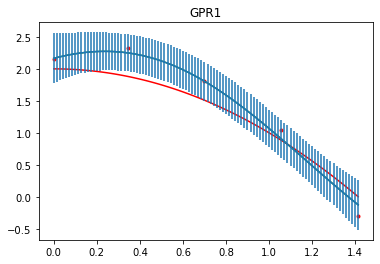

In [88]:
#KERNEL: exponential square kernel
def Kernel(x1,x2,params):
    amp = params[0]
    'How far should be between x1 and x2 for f(x1) to be uncorrelated with f(x2)'
    l = params[1]
    return amp**2 * np.exp(-((x1-x2)*(x1-x2))/(2*l**2))



X1, X2 = np.meshgrid(xd,xd)
X1st, X2st = np.meshgrid(x,x)
X1st2, X22 = np.meshgrid(x,xd)


#optimising kernel paramaters via marginal likelyhood
def MargLi(params):
    K, R, cov_li = KRcov_li(params,exp_er)
    invertable = cov_li+R@K@R.T
    #add a small term onto diagonal of matricies to be inverted.
    #this ensures it is positive definate and cholensky matrix can be computed
    invertable[np.diag_indices_from(invertable)] += 1e-8 
    return 0.5*np.log(chol_det(cov_li + R@K@R.T)) + 0.5*(yd.T@chol_inv(cov_li+R@K@R.T)@yd)                

x0=[3.15,0.096]
results = minimize(MargLi, x0=x0)
# results = basinhopping(MargLi, x0=x0, niter=200)
print('\n\nRESULTS',results)
best_params = results.x
# best_params = x0

# print('\n\nMargLi',MargLi(best_params))

K = Kernel(X1,X2,best_params)
#add a small term onto diagonal of matricies to be inverted.
#this ensures it is positive definate and cholensky matrix can be computed
K[np.diag_indices_from(K)] += 1e-8 

Kstst = Kernel(X1st, X2st,best_params)
Kst = Kernel(X22, X1st2,best_params)
##Data Dist, has prior in it
mu_D = prior_mean_vector
cov_D = K + np.diag(np.repeat(exp_er,len(xd)))


print('Probably not good if 0. cov_D definetly cannot be 0 as it is inverted.')
# print('The Determinent of K is:', chol_det(K))
# print('The Determinent of Kst is:', chol_det(Kst))
# print('The Determinent of Kstst is:', chol_det(Kstst))
# print('The Determinent of cov_D is:', chol_det(cov_D))
##Predictions dist
mu_yst = np.repeat(0,N)
cov_yst = Kstst



cov_post1 = Kstst - Kst.T @ chol_inv(cov_D) @ Kst
mu_post1 = Kst.T @ chol_inv(cov_D) @ yd
error_bars1 = np.sqrt(np.diagonal(cov_post1))


figGPR1 = plt.figure()
plt.title('GPR1')
plt.plot(x,y,'r')
plt.plot(xd,yd,'r.')
plt.plot(x,mu_post1,'g')
plt.errorbar(x, mu_post1, yerr=error_bars1)
plt.show()

# Gaussian Process 1 Including Gradient Information From Cholskey Method

should be equilivant to hao wu's method but my version gets numerical errors

In [103]:
#KERNEL: exponential square kernel
def Kernel(x1,x2,params):
    amp = params[0]
    'How far should be between x1 and x2 for f(x1) to be uncorrelated with f(x2)'
    l = params[1]
    return amp**2 * np.exp(-((x1-x2)*(x1-x2))/(2*l**2))

def KernelPrime(x1,x2,params):
    amp = params[0]
    'How far should be between x1 and x2 for f(x1) to be uncorrelated with f(x2)'
    l = params[1]
    return Kernel(x1,x2,params) * 1/l**2 * x1-x2

    
def KernelPrimePrime(x1,x2,params):
    amp = params[0]
    'How far should be between x1 and x2 for f(x1) to be uncorrelated with f(x2)'
    l = params[1]
    return KernelPrime(x1,x2,params) * (x1-x2)/l**2 - 1/l**2 * amp * Kernel(x1, x2, params)

#K box **, top left, top right, bottom right
Xprprstst1, Xprprstst2 = np.meshgrid(xprime, xprime)
Xprststj1, Xprststj2 = np.meshgrid(x, xprime)
Xstst1, Xstst2 = np.meshgrid(x,x)
Xprststi1, Xprststi2 = np.meshgrid(xprime, x)

#K box *
Xprprst1, Xprprst2 = np.meshgrid(xdprime,xprime)
Xprstj1, Xprstj2 = np.meshgrid(xd,xprime)
Xst1, Xst2 = np.meshgrid(xd,x)
Xprsti1, Xprsti2 = np.meshgrid(xdprime,x)
print(Xprstj1.shape, Xprstj2.shape)

# K box
Xprpr1, Xprpr2 = np.meshgrid(xdprime, xdprime)
Xprj1, Xprj2 = np.meshgrid(xd, xdprime)
X1, X2 = X1, X2 = np.meshgrid(xd,xd)
Xpri1, Xpri2 = np.meshgrid(xdprime, xd)


# X1, X2 = np.meshgrid(xd,xd)
# Xstst1, Xstst2 = np.meshgrid(x,x)
# Xst1, Xst2 = np.meshgrid(x,xd)

#optimising kernel paramaters via marginal likelyhood
# def MargLi(params):
#     K, R, cov_li = KRcov_li(params,exp_er)
#     invertable = cov_li+R@K@R.T
#     #add a small term onto diagonal of matricies to be inverted.
#     #this ensures it is positive definate and cholensky matrix can be computed
#     invertable[np.diag_indices_from(invertable)] += 1e-8 
#     return 0.5*np.log(chol_det(cov_li + R@K@R.T)) + 0.5*(yd.T@chol_inv(cov_li+R@K@R.T)@yd)                

x0=[3.15,0.096]
# results = minimize(MargLi, x0=x0)
# results = basinhopping(MargLi, x0=x0, niter=200)
# print('\n\nRESULTS',results)
# best_params = results.x
best_params = x0

# print('\n\nMargLi',MargLi(best_params))

#clockwise starting from top left
Kboxstst1 = KernelPrimePrime(Xprprstst1,Xprprstst2,best_params)
Kboxstst2 = KernelPrime(Xprststj1,Xprststj2,best_params)
Kboxstst3 = Kernel(Xstst1,Xstst2,best_params)
Kboxstst4 = KernelPrime(Xprststi1,Xprststi2,best_params)

Kboxst1 = KernelPrimePrime(Xprprst1,Xprprst2,best_params)
Kboxst2 = KernelPrime(Xprstj1,Xprstj2,best_params)
Kboxst3 = Kernel(Xst1,Xst2,best_params)
Kboxst4 = KernelPrime(Xprsti1,Xprsti2,best_params)

Kbox1 = KernelPrimePrime(Xprpr1,Xprpr2,best_params)
Kbox2 = KernelPrime(Xprj1,Xprj2,best_params)
Kbox3 = Kernel(X1,X2,best_params)
Kbox4 = KernelPrime(Xpri1,Xpri2,best_params)

def FourIn1(A,B,C,D):
    #starts top left and gloes clockwise, A B C D
    print('4in1')
    print(A.shape,B.shape,C.shape,D.shape)
    one = np.concatenate((A,B),axis=1)
    two = np.concatenate((D,C),axis=1)
    return np.concatenate((one,two),axis = 0)

Kboxstst = FourIn1(Kboxstst1,Kboxstst2,Kboxstst3,Kboxstst4)
Kboxst = FourIn1(Kboxst1,Kboxst2,Kboxst3,Kboxst4)
Kbox = FourIn1(Kbox1,Kbox2,Kbox3,Kbox4)

#add a small term onto diagonal of matricies to be inverted.
#this ensures it is positive definate and cholensky matrix can be computed
Kbox[np.diag_indices_from(Kbox)] += 1e-8 

##Data Dist, has prior in it
mu_D = np.array([0 for i in range(M+Mprime)])#prior_mean_vector 
exp_er_prime = 0.0001
cov_D = Kbox + np.diag(np.concatenate((np.repeat(exp_er,M), np.repeat(exp_er_prime,Mprime))))
cov_D[np.diag_indices_from(cov_D)] += 1e-8 

print('Probably not good if 0. cov_D definetly cannot be 0 as it is inverted.')
# print('The Determinent of K is:', chol_det(K))
# print('The Determinent of Kst is:', chol_det(Kst))
# print('The Determinent of Kstst is:', chol_det(Kstst))
# print('The Determinent of cov_D is:', chol_det(cov_D))
##Predictions dist
mu_yst = np.repeat(0,N)
cov_yst = Kstst



cov_post = Kboxstst - Kboxst.T @ chol_inv(cov_D) @ Kboxst
mu_post = Kboxst.T @ chol_inv(cov_D) @ np.contatenate((ydprime,yd))

error_bars = np.diagonal(cov_post)

mu_post_yst = mu_post[Mprime:]
error_bars_yst = np.diagonal(cov_post)[Mprime:]


figGPR1 = plt.figure()
plt.title('GPR1')
plt.plot(x,y,'r')
plt.plot(xd,yd,'r.')
plt.plot(x,mu_post_yst,'g')
plt.errorbar(x, mu_post_yst, yerr=error_bars_yst)
plt.show()

(50, 5) (50, 5)
4in1
(50, 50) (50, 100) (100, 100) (100, 50)
4in1
(50, 1) (50, 5) (100, 5) (100, 1)
4in1
(1, 1) (1, 5) (5, 5) (5, 1)
Probably not good if 0. cov_D definetly cannot be 0 as it is inverted.


LinAlgError: Matrix is not positive definite

In [ ]:
import optuna

def objective(trial):
    amp = trial.suggest_float('amp', 0, 22)
    l = trial.suggest_float('l', 0, 4)
    params = [amp,l]
    return MargLi(params)
    
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=500)

study.best_params

## Before Kernel Optimisation

The performance is highly unstable. The errors vary from wildly large to extreamly tiny. The mean vector can look like gaussian noise or closely matching the profile. Also if the space between data points to too small the kernel covariance matric seems to have a determinent of 0 and thus no inverse. Some kernel parameters also cause this to hapen. It can happen in the other matracies aswell. This can cause errors in the code if the matrix is to be inveresed. It also causes the error bars to swing from almost infinity to almost 0. 

## After Kernel Optimisation

GP1 works extreamly well after kernel optimisation. Knowing exactly how the kernel parameters influence the graph can help dramatically for selecting a prior with optuna, or initial guesses for scipy.optimise(). The amp, sets how easy it is for the posterior mean to get far from the prior mean. The higher this is the weaker the prior is. The length scale l, sets how correlated two points are. For two points with one specific x distance apart, they are said to be more correlated is l is large and less correlated if l is small. We use how correlated they are in x as exactly how correlated they are in y.  

# Gaussian Process Regression 2
See notes, uses bayes theorum but must have the same x position for data and predictions. 

# Ignore this one for now

(14,)


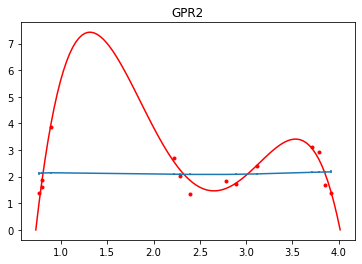

In [90]:
#exponential square kernel
def kernel(x1,x2):
    a = 10
    b = 10
    return a * np.exp(-((x1-x2)*(x1-x2))/b)
X1, X2 = np.meshgrid(xd,xd)
prior_cov = kernel(X1,X2) #np.diag(np.repeat(exp_er,len(x)))#
likelyhood_cov = np.diag(np.repeat(exp_er,len(xd)))
#Now we make the gaussian process distribution for the likelyhood
likelyhood = mnorm(mean=yd, cov=likelyhood_cov)
prior = mnorm(mean=np.repeat(0,len(xd)),cov=prior_cov, allow_singular=True)

#posterior_mean = inv(inv(prior_cov)+inv(likelyhood_cov)) @ (inv(prior_cov)@likelyhood.mean+inv(likelyhood_cov)@prior.mean)
posterior_mean = prior_cov @ inv(prior_cov + likelyhood_cov) @ likelyhood.mean  +  likelyhood_cov @ inv(prior_cov + likelyhood_cov) @ prior.mean
posterior_cov = prior_cov @ inv(prior_cov + likelyhood_cov) @ likelyhood_cov
error_bars2 = np.diagonal(posterior_cov)

print(np.shape(posterior_mean))
figGPR2 = plt.figure()
plt.title('GPR2')
plt.plot(x,y,'r')
plt.plot(xd,yd,'r.')
# plt.plot(x,posterior_mean,'g')
plt.errorbar(xd,posterior_mean, yerr=error_bars2)
plt.show()